In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

## **4차원 배열**

In [3]:
x = np.random.rand(10, 1, 28, 28) # 높이 28, 너비 28, 채널 1개인 데이터가 10개
x.shape

(10, 1, 28, 28)

In [4]:
x[0].shape # 첫 번째 데이터에 접근

(1, 28, 28)

In [5]:
x[0][0] # 첫 번째 데이터의 첫 채널의 공간 데이터에 접근

array([[0.39847256, 0.1997792 , 0.35920803, 0.6175381 , 0.00271316,
        0.83845123, 0.23060389, 0.59667238, 0.19776184, 0.78727703,
        0.50564659, 0.78703307, 0.02558828, 0.11321511, 0.38514646,
        0.76462539, 0.11741679, 0.34388019, 0.31990199, 0.80048197,
        0.33600489, 0.03487236, 0.89753161, 0.96007563, 0.0690366 ,
        0.48609242, 0.99642828, 0.16543936],
       [0.27496271, 0.95216997, 0.51456434, 0.2569952 , 0.90169588,
        0.96425148, 0.31768271, 0.21508249, 0.39516769, 0.40708922,
        0.86198259, 0.18615325, 0.00676358, 0.24712187, 0.59529668,
        0.5627158 , 0.1360914 , 0.33692011, 0.14953099, 0.72315748,
        0.94405169, 0.30823754, 0.20629883, 0.34087127, 0.03114606,
        0.98852759, 0.68315548, 0.13089124],
       [0.44502511, 0.62677531, 0.98451539, 0.40498763, 0.84739428,
        0.3113402 , 0.75163855, 0.80391891, 0.26550603, 0.80225167,
        0.58531889, 0.48079878, 0.88562754, 0.99486731, 0.9076289 ,
        0.95203011, 0.1762

## **합성곱 계층 구현하기**

In [6]:
# im2col(image to column) 함수 구현

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [7]:
# im2col 사용해보기

x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(9, 75)


im2col을 통해 4차원 배열의 데이터가 2차원 행렬로 출력된 것을 알 수 있다.

따라서 im2col은 메모리를 더 많이 소비하는 단점이 있지만서도 행렬 계산에 고도로 최적화되엉 있는 라이브러리들을 활용해 큰 행렬의 곱셈을 빠르게 계산할 수 있다.

In [8]:
x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90,75)

(90, 75)


2번째 차원의 원소는 75개이다. 이 값은 필터의 원소 수와 같다(채널3개, 5 X 5 데이터)

또한, 배치크기가 1에서 10이 되면 마찬가지로 1번째 차원의 원소 또한 10배가 된다.

In [9]:
# 합성곱 계층 구현

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1+ (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개 ex) (10, 3, 5, 5) 형상의 데이터의 원소 수는 총 750개 이므로, reshape(10, -1)을 호출하면 750개의 원소를 10묶음으로, (10, 75)인 배열로 만들어 준다.
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) # 출력데이터를 적절한 형상으로 바꿔준다. 인덱스로 축의 순서를 변경한다.

        return out

im2col로 전개한 덕분에 완전연결 계층의 Affine 계층과 거의 똑같이 구현할 수 있다.

합성곱 계층의 역전파에서 주의할 점은 im2col을 역으로 처리하는 col2im 함수를 사용해야 한다.

## **풀링(pooling) 계층 구현하기**

풀링의 경우엔 채널 쪽이 독립적이기 때문에 풀링 적용 영역을 채널마다 독립적으로 전개한다.

In [10]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값 (2)
        out = np.max(col, axis=1) # 입력 x의 1번째 차원의 축마다 최댓값을 구한다. **주의 : 2차원 배열(행렬)에서 axis=1은 행 방향을 뜻한다.

        # 성형 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

앞서 보았듯이 풀링 계층 구현은 다음과 같이 세 단계로 진행된다.

1. 입력 데이터를 전개한다.
2. 행별 최댓값을 구한다.
3. 적절한 모양으로 성형한다.

## **CNN 구현하기**

* input_dim - 입력 데이터(채널 수, 높이, 너비)의 차원
* conv_param = 합성곱 계층의 하이퍼파라미터(딕셔너리). 딕셔너리의 키는 다음과 같다.
    - filter_num - 필터수
    - filter_size - 필터크기
    - stride - 스트라이드
    - pad - 패딩
* hidden_size - 은닉층(완전연결)의 뉴런 수
* output_size - 출력층(완전연결)의 뉴런 수
* weight_init_std - 초기화 때의 가중치 표준편차
    * 'relu'나 'he'로 지정하면 'He 초깃값'
    * 'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정

In [11]:
import sys
sys.path.append('/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master')
import pickle
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    
    # 초기화 인수로 주어진 CNN의 하이퍼파라미터를 나중에 쓰기 쉽도록 딕셔너리에서 꺼낸다. 그리고 합성곱 계층의 출력 크기를 계산한다.
    def __init(self, input_dim = (1, 28, 28), 
               conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
               hidden_size = 100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 매개변수를 초기화 한다.
        self.params = {}
        # 1번째 층
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # 2번째 층
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # 3번째 층
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # CNN을 구성하는 계층들 생성
        self.layers = OrderedDict() # 순서가 있는 딕셔너리에 저장
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss() # 마지막 계층은 last_layer라는 별도 변수에 저장

    # 추론과 손실 함수 구하기
    def predict(self, x):
        for lyaer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    # 오차역전파법으로 기울기 구하기
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.revers()
        for layer in layers:
            dout = lyaer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## **SimpleCovNet으로 MINST 데이터셋 학습**

train loss:2.298316411642773
=== epoch:1, train acc:0.272, test acc:0.282 ===
train loss:2.295530437022263
train loss:2.2937045864137566
train loss:2.288125016465555
train loss:2.277892195192799
train loss:2.2684331972821408
train loss:2.256919096146327
train loss:2.2241714965689043
train loss:2.2130246165046037
train loss:2.1943517530601335
train loss:2.1486750134225163
train loss:2.116214350126084
train loss:2.0904741022943854
train loss:2.0367826349485325
train loss:1.9726251022856462
train loss:1.850969990177189
train loss:1.7933364565853598
train loss:1.7720516081536324
train loss:1.7203081644505125
train loss:1.6830183488248533
train loss:1.4923693359119325
train loss:1.5205874313682963
train loss:1.345597306744823
train loss:1.385076303512217
train loss:1.2371742944634352
train loss:1.1708484025254458
train loss:1.1052390719085652
train loss:1.153997637282493
train loss:1.0462833957463196
train loss:0.8725802435596249
train loss:0.8546015985231195
train loss:0.9133529813007978
t

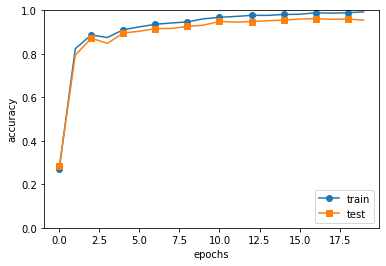

In [15]:
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

시험 데이터에 대한 정확도가 아주 높게 나오는 것을 볼 수 잇다.

## **1번째 층의 가중치 시각화하기**

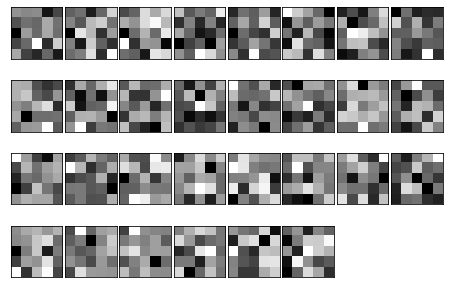

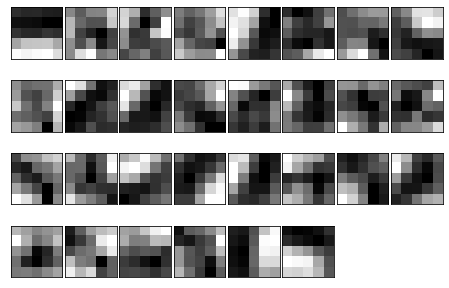

In [25]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
        
    plt.show()

network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

첫 번째에서는 학습 전 필터는 무작위로 초기화되고 있어 흑백의 정도에 규칙성이 없지만, 두 번째의 학습을 마친 필터는 규칙성 있는 이미지가 되었다.

규칙성 있는 필터가 보고 있는 것은 에지(섹상이 바뀐 경계선)와 블롭(국소적으로 덩어리진 영역)이다.

이처럼 합성곱 계층의 필터는 에지나 블롭 등의 원시적인 정보를 추출할 수 있다.

이런 원시적인 정보가 뒷단 계층에 전달된다는 것이 앞에서 구현한 CNN에서 일어나는 일이다.

## **층 깊이에 따른 추출 정보 변화**

합성곱 계층을 여러 겹 쌓으면, 층이 깊어지면서 더 복잡하고 추상화된 정보가 추출된다.

처음 층은 단순한 에지에 반응하고, 이어서 텍스처에 반응하고, 더 복잡한 사물의 일부에 반응하도록 변화한다.

즉, 층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 '고급'정보로 변화해간다. 다시 말해 사물의 '의미'를 이해하도록 변화한다.

## **대표적인 CNN - LeNet**

**LeNet**은 손글씨 숫자를 인식하는 네트워크이다. 합성곱 계층과 풀링 계층(정확히는 단순히 '원소를 줄이기만'하는 서브샘플링 계층)을 반복하고, 마지막으로 완전연결 계층을 거치면서 결과를 출력한다.

LeNet과 '현재의 CNN'의 차이점
* LeNet은 활성화 함수로 시그모이드 함수를 사용하지만 현재는 주로 ReLU를 사용한다.
* 원래의 LeNet은 서브샘플링을 하여 중간 데이터의 크기를 줄이지만 현재는 최대 풀링이 주류이다.

## **대표적인 CNN - AlexNet**

LeNet과 비교해 훨씬 최근에 발표된 **AlexNet**은 딥러닝 열풍을 일으키는데 큰 역할을 하였다.

구성은 기본적으로 LeNet과 크게 다르지 않지만 다음과 같은 변화가 있다.
* 활성화 함수로 ReLU를 이용한다.
* LRN(Local Response Normalization)이라는 국소적 정규화를 실시하는 계층을 이용한다.
* 드롭아웃을 사용한다.

LeNet과 AlexNet에 큰 차이는 없지만, 컴퓨팅 기술의 발전,
병렬 계산에 특화된 GPU와 빅데이터, 이것이 딥러닝 발전의 큰 원동력이다.

# **정리**

* **CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.**
* **합성곱 계층과 풀링 계층은 im2col(이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율적으로 구현할 수 있다.**
* **CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.**
* **대표적인 CNN에는 LeNet과 AlexNet이 있다.**
* **딥러닝의 발전에는 빅데이터와 GPU가 크게 기여했다.**